# Анализ оттока клиентов фитнесс-клуба

**Цель проекта**: анализ оттока и разработка плана по удержанию клиентов фитнесс-клуба "Культурист-датасаентист".

**Задачи:**
- прогноз вероятности оттока на уровне месяца;
- формирование типичных портретов клиентов и описание их характеристик;
- анализ основных признаков, влияющих на отток клиентов;
- разработка рекомендаций по работе с клиентами в целях снижения оттока. 


Содержание:
1. [Описание данных](#id_description)
2. [Импорт библиотек](#import)
3. [Предобработка и исследовательский анализ данных](#eda_id)
    - [Исследование данных с учетом признака оттока](#groups)
4. [Прогнозирование оттока клиентов](#churn_prediction)
5. [Кластеризация клиентов](#clusters)
6. [Выводы и рекомендации](#conclusions)

## Описание данных<a id="id_description"></a>

Набор данных включает следующие поля:

- $Churn$ - факт оттока в текущем месяце;
- $gender$ - пол;
- $Near$_$Location$ - проживание или работа в районе, где находится фитнес-центр;
- $Partner$ - сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент в таком случае фитнес-центр хранит информацию о работодателе клиента);
- $Promo$_$friends$ - факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- $Phone$ - наличие контактного телефона;
- $Age$ - возраст;
- $Lifetime$ - время с момента первого обращения в фитнес-центр в месяцах. 

Выше указанные данные представлены за предыдущий до проверки факта оттока месяц. 

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- $Contract$_$period$ — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
- $Month$_ $to$_ $end$_$contract$ — срок до окончания текущего действующего абонемента (в месяцах);
- $Group$_$visits$ — факт посещения групповых занятий;
- $Avg$_ $class$_ $frequency$_$total$ — средняя частота посещений в неделю за все время с начала действия абонемента;
- $Avg$_ $class$_ $frequency$_ $current$_$month$ — средняя частота посещений в неделю за предыдущий месяц;
- $Avg$_ $additional$_ $charges$_$total$ — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

## Импорт библиотек<a id = 'import'></a>

In [1]:
!pip install seaborn -U
!pip install matplotlib.pyplot -U
!pip install pandas -U

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.1)
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot
Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: pandas in /home/jovyan/.local/lib/python3.7/site-packages (1.3.1)


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from scipy import stats as st
from math import factorial
import math as mth

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import os

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

## Предобработка и исследовательский анализ данных<a id = 'eda_id'><a/>

In [7]:
#прочитаем данные
path = 'C:/Python/datasets/'

if os.path.exists(path):
    df = pd.read_csv(path + 'gym_churn.csv')
else:
    df = pd.read_csv('/datasets/gym_churn.csv')
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Для удобства дальнейшей работы приведем названия столбцов к единому типу:

In [8]:
df.rename(columns = {'Near_Location':'near_location',
                    'Partner':'partner',
                     'Promo_friends':'promo_friends', 'Phone':'phone', 
                     'Contract_period':'contract_period', 'Group_visits':'group_visits',
                     'Age':'age', 'Avg_additional_charges_total':'avg_additional_charges_total',
                     'Month_to_end_contract':'month_to_end_contract',
                     'Lifetime':'lifetime',
                     'Avg_class_frequency_total':'avg_class_frequency_total',
                     'Avg_class_frequency_current_month':'avg_class_frequency_current_month',
                     'Churn':'churn'
                    }, inplace = True)

In [9]:
df.columns = map(str.lower, df.columns)

Посмотрим на размер датасета и информацию о данных:

In [10]:
display(df.shape)
df.info()

(4000, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Пропусков значений нет. Типы данных представлены целыми числами или числами с плавающей точкой. 

In [11]:
#наличие дупликатов:
df.duplicated().sum()

0

Дупликатов нет.

Посмотрим на разброс данных: средние значения признаков и стандартные отклонения:

In [12]:
#non binary columns:
df.drop(['churn', 'gender', 'near_location', 'partner', 'promo_friends', 
        'phone', 'group_visits'], axis = 1).describe()

,contract_period,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,4.681250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052
std,4.549706,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906
min,1.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000
25%,1.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003
50%,1.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574
75%,6.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336
max,12.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783


Солбцы "contract_period" и "month_to_end_contract" избыточны с точки зрения содержащейся информации и могут негативно повлиять на обучение линейной модели, и должны быть учтены в дальнейшем при регуляризации. Посмотрим на их распределение на гистограмме:

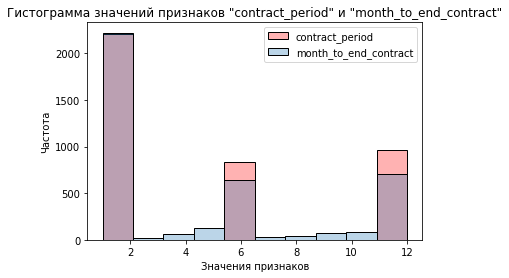

In [13]:
plt.figure()
ax = sns.histplot(data = df['contract_period'], color = 'red', alpha = 0.3, label = 'contract_period', bins = 10)
ax = sns.histplot(data = df['month_to_end_contract'], alpha = 0.3, label = 'month_to_end_contract', bins = 10)
plt.legend()
ax.set_xlabel('Значения признаков')
ax.set_ylabel('Частота')
plt.title('Гистограмма значений признаков "contract_period" и "month_to_end_contract"')
plt.show()

Для большинства пользователей срок до окончания абонемента составляет 1, 6 или 12 месяцев, что коррелирует с вариантами абонементов фитнес-клуба: 1, 6 и 12 месяцев.

In [14]:
df['contract_period'].unique()

array([ 6, 12,  1])

Стандартные отклонения признаков avg_class_frequency_total и avg_class_frequency_current_month не очень высокие, распределение нормальное но смещено вправо. Для данной пары признаков также вероятна мультиколлинеарность. Посмотрим на распределение:

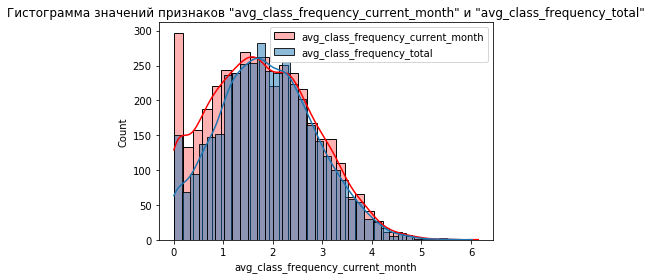

In [15]:
plt.figure()
sns.histplot(df['avg_class_frequency_current_month'], kde = True, color = 'red', alpha = 0.3, 
             label = 'avg_class_frequency_current_month')
sns.histplot(df['avg_class_frequency_total'], kde = True, label = 'avg_class_frequency_total')
plt.legend()
ax.set_xlabel('Значения признаков')
ax.set_ylabel('Частота')
plt.title('Гистограмма значений признаков "avg_class_frequency_current_month" и "avg_class_frequency_total"')
plt.show()

Остальные признаки: age, avg_additional_charges_total и lifetime имеют более высокие значения стандартного отклонения. Значения age распределены нормально. Признаки avg_additional_charges_total и lifetime распределены согласно распределению Пуассона.

In [16]:
#non binary columns:
df[['churn', 'gender', 'near_location', 'partner', 'promo_friends', 
        'phone', 'group_visits']].describe()

,churn,gender,near_location,partner,promo_friends,phone,group_visits
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.265250,0.510250,0.845250,0.486750,0.308500,0.903500,0.412250
std,0.441521,0.499957,0.361711,0.499887,0.461932,0.295313,0.492301
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Стандартные отклонения большинства (churn, gender, partner, promo_friends, group_visits) бинарных признаков довольно высокие, что говорит о большом разбросе данных.

На распределение бинарных признаков лучше посмотреть на графике:

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


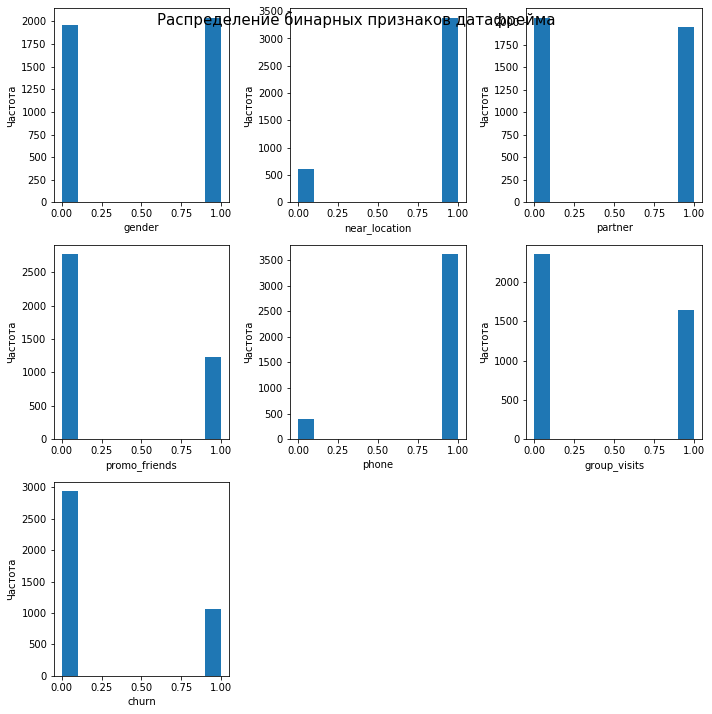

In [17]:
df_10 = df[['gender', 'near_location', 'partner', 'promo_friends','phone', 'group_visits', 'churn']]
#columns and rows of the plot:
ncols = 3
nrows = int(np.ceil(len(df_10.columns) / (1.0*ncols)))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
fig.suptitle('Распределение бинарных признаков датафрейма', fontsize=15)
#plot
counter = 0
for i in range(nrows):
    for j in range(ncols):

        ax = axes[i][j]
        # Plot when we have data
        if counter < len(df_10.columns):

            ax.hist(df_10[df_10.columns[counter]])
            ax.set_xlabel('{}'.format(df_10.columns[counter]))
            ax.set_ylabel('Частота')
            leg = ax.legend(loc='upper left')
            leg.draw_frame(False)

        # Remove axis when we no longer have data
        else:
            ax.set_axis_off()

        counter += 1
plt.tight_layout()
plt.show()


Таким образом, видно, что пол и наличие членства компании в партнерах клуба имеют распределение близкое к 1:1. Остальные признаки распределены неравномерно и имеют одно значение признака превалирующим, в разной степни для разных признаков. 

### Исследование данных с учетом признака оттока <a id = 'groups'></a>

Далее посмотрим на средние значения признаков в группах тех, кто ушел и тех, кто остался, отразив их в сводной таблице:

In [18]:
df_churn = df.groupby('churn').agg('mean')
df_churn = df_churn.T
df_churn['abs'] = (df_churn[0] - df_churn[1]).abs()
df_churn['abs_perc'] = (df_churn['abs']/(df_churn[0] + df_churn[1]))*100
df_churn.sort_values(by = 'abs_perc', ascending = False)

churn,0,1,abs,abs_perc
lifetime,4.711807,0.990575,3.721232,65.257502
contract_period,5.747193,1.728558,4.018635,53.755603
month_to_end_contract,5.283089,1.662582,3.620507,52.126087
avg_class_frequency_current_month,2.027882,1.044546,0.983336,32.005188
promo_friends,0.353522,0.183789,0.169733,31.589320
group_visits,0.464103,0.268615,0.195489,26.679969
partner,0.534195,0.355325,0.178870,20.108603
avg_additional_charges_total,158.445715,115.082899,43.362816,15.853119
avg_class_frequency_total,2.024876,1.474995,0.549881,15.711467
near_location,0.873086,0.768143,0.104943,6.394160


Так, можно наблюдать самую большую разницу между ушедшими и оставшимися клиентами по признакам периода членства (lifetime) и длительности контракта (contract_period, month_to_end_contract). Также, довольно сильные различия в группах наблюдаются по признакам avg_class_frequency_current_month (скорее всего связано с наличием большого количества новых клиентов, которые уйдут после короткого периода), promo_friends, group_visits и partner, что очень логично.

Построим гистограммы распределения признаков для двух групп - тех, кто ушел и тех, кто остался:

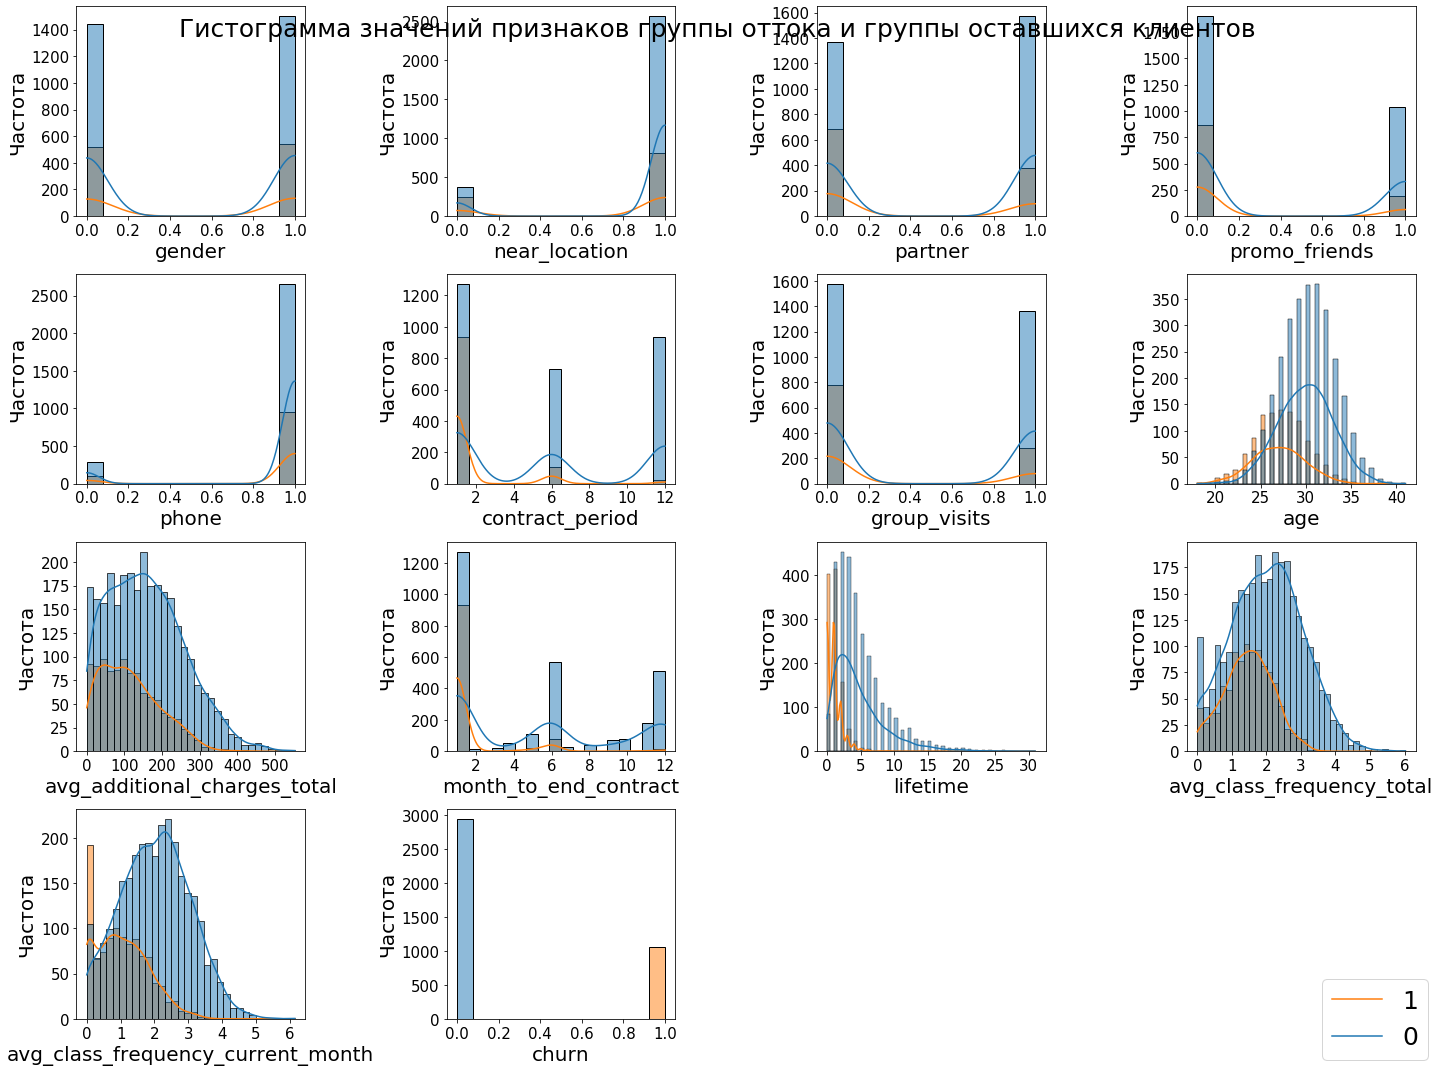

In [19]:
ncols = 4
nrows = int(np.ceil(len(df.columns) / (1.0*ncols)))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15))
fig.suptitle('Гистограмма значений признаков группы оттока и группы оставшихся клиентов', fontsize=25)
#plot
counter = 0
for i in range(nrows):
    for j in range(ncols):
        # Plot when we have data
        ax = axes[i][j]
        if counter < len(df.columns):
            ax = sns.histplot(data = df, x = df[df.columns[counter]], kde = True, color = 'skyblue', hue = 'churn', 
                         ax = ax, alpha = 0.5, legend = False)
            #ax = sns.displot(df, x=df[df.columns[counter]], hue="churn", stat="density", ax = ax)
            ax.set_xlabel('{}'.format(df.columns[counter]), fontsize = 20)
            ax.set_ylabel('Частота', fontsize = 20)
            plt.setp(ax.get_xticklabels(), fontsize=15)
            plt.setp(ax.get_yticklabels(), fontsize=15)

        # Remove axis when we no longer have data
        else:
            ax.set_axis_off()

        counter += 1
plt.tight_layout()
fig.legend([1, 0], loc = 4, fontsize = 25)
plt.show()




Многие распределения имеют сильные различия для разных групп (churn 1/ churn 0). Интересен пик в значениях близких к 0 для признака avg_class_frequancy_current_month в группе оттока, и его отсутствие для признака avg_class_frequency_total. Возможно, определенная часть клиентов группы оттока вообще не приходят в зал.  

Среди тех, кто остался больше клинтов, являющихся сотрудниками компаний-партнёров клуба, а среди тех, кто ушел больше тех, кто не является сотрудниками таких компаний. Вероятно, партнерство действительно способствует удержанию постоянных клиентов.

Также, наблюдается меньший процент тех, кто посещает групповые занятия среди клиентов из группы оттока. 

Посмотрим на корреляции признаков:

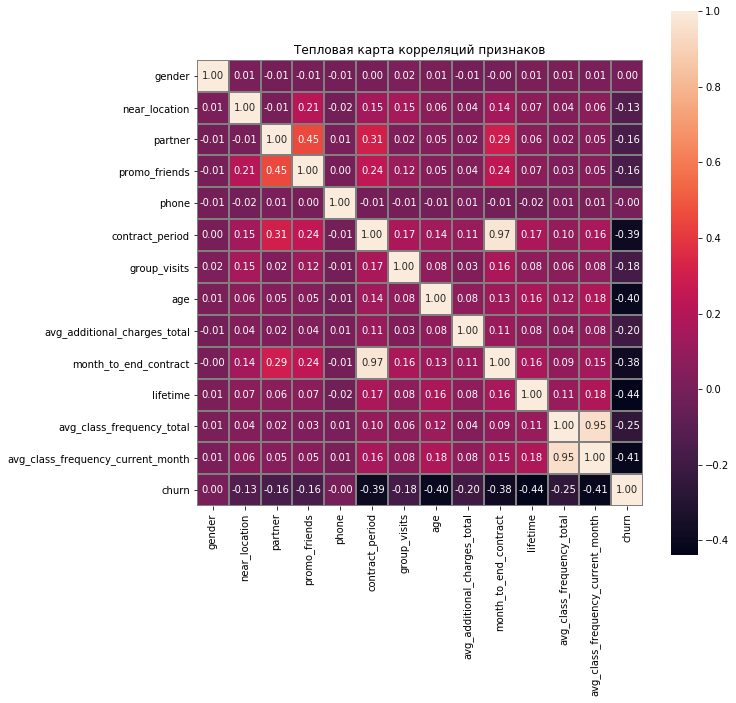

In [20]:
plt.figure(figsize = (10,10))
cm = df.corr()
sns.heatmap(cm, annot = True, square=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.title('Тепловая карта корреляций признаков')
plt.show()

Можно отметить слабую негативную корреляцию факта оттока с периодом контракта, возрастов клиентов, количеством месяцев до окончания контракта, lifetime и среднее частотой посещений за данный месяц. Также наблюдается слабая положительная корреляция признаков promo_friend и partner, что скорее всего связано с распространением информации и привлечением клиентов через коллег-членов клуба. 

Очень сильная корреляция наблюдается для признаков month_to_end_contract и contract_period, а также для avg_class_frequency_current_month и avg_class_frequency_total. Данная связь объясняется тем, что данные признаки коллинеарны. 

## Прогнозирование оттока клиентов<a id = 'churn_prediction'><a/>

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце. 

In [21]:
# разделим данные на признаки (матрица X) и целевую переменную (y)
X = df.drop(columns=['churn'])
y = df['churn']
#разобьем данные на обучающую и валидационную (20%) выборки:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Обучим модель с помощью двух способов: логистической регрессией и случайным лесом и вычислим метрики precision, recall, f1_score и roc_auc score. Метрика accuracy не подходит для данного датасета, так как классы распределены неравномерно: группа оттока меньше группы тех, кто остался. 

In [22]:
#Logistic Regression
lr_model = LogisticRegression(random_state = 0, solver='liblinear')
lr_model.fit(X_train, y_train)
#прогнозирование:
probabilities = lr_model.predict_proba(X_test)[:, 1]
predictions = lr_model.predict(X_test)
#метрики:
print('Метрики для Logistic Regression:')
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions)))
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, probabilities)))

Метрики для Logistic Regression:
Precision: 0.86
Recall: 0.83
F1: 0.85
ROC_AUC: 0.97


Логистическая регрессия работает очень хорошо на данном наборе данных. Около 85% прогнозов верны. 

In [23]:
#random forest
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]
#метрики:
print('Метрики для Random Forest:')
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, rf_predictions)))
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, rf_probabilities)))

Метрики для Random Forest:
Precision: 0.84
Recall: 0.82
F1: 0.83
ROC_AUC: 0.97


Модель случайного леса имеет практически такую же точность, но все же немного уступает логистической регрессии. 

Таким образом, модель логистической регрессии наиболее эффективна.

## Кластеризация клиентов<a id = 'clusters'><a/>

Для начала стандартизируем данные.

In [24]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

Построим матрицу расстояний функцией linkage(). 

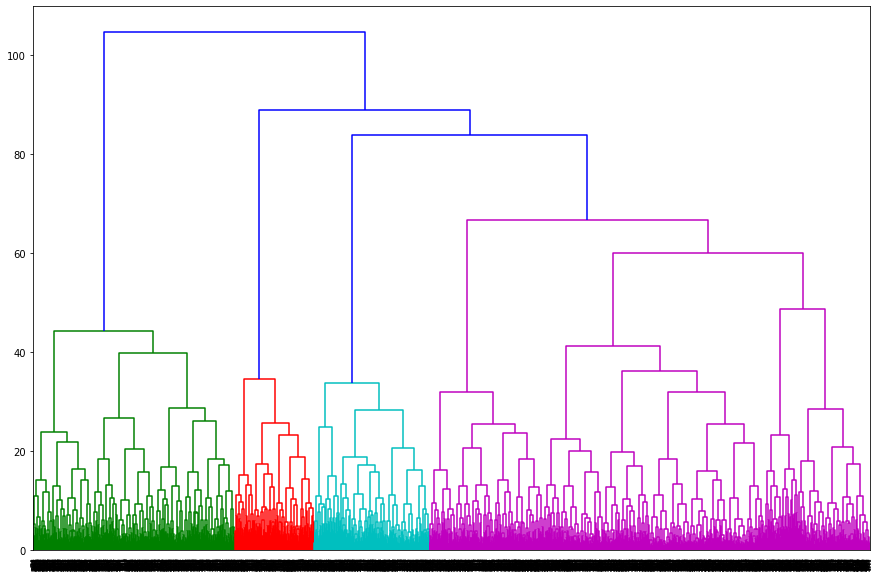

In [25]:
linked = linkage(X_sc, method = 'ward') 
#plot
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

Таким образом, оптимальное число кластеров - 4. Зададим модель на основании алгоритма K-means c числом кластеров n=4.

In [26]:
km = KMeans(n_clusters = 4, random_state = 0) ### нужен random_state
# прогнозируем кластеры для имеющихся данных (алгоритм присваивает им номера от 0 до 3)
labels = km.fit_predict(X_sc) #без обучения, так как модель без учителя.

Создадим новый столбец в датафрейме, содержащий информацию о кластере:

In [27]:
df['cluster_km'] = labels

In [28]:
df.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,cluster_km
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0,3
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0,1
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0,3
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0,1


Посмотрим на средние значения признаков во всех кластерах:

In [29]:
df.groupby('cluster_km').agg('mean')

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967,0.266839
1,0.486815,0.759297,0.381339,0.190669,1.0,1.899256,0.292765,28.048005,129.704525,1.805274,2.235294,1.204610,0.951590,0.559838
2,0.544939,0.861873,0.343425,0.205298,1.0,2.403027,0.447493,29.989593,157.358764,2.239357,4.704825,2.724796,2.711132,0.092715
3,0.503711,0.940631,0.777365,0.572356,1.0,10.697588,0.536178,29.912801,161.363032,9.768089,4.730056,1.983884,1.975592,0.029685


Можно сразу отметить различия по отдельным признака между кластерами. Так, **кластер 3** имеет более высокие средние значения contact_period, partner, group_visits, avg_additional_charges_total, month_to_end_contract и **наименьший отток** по сравнению с другими кластерами. То есть данная группа клиентов наиболее надежна и постоянна. Можно заключить, что такие клиенты чаще являются сотрудниками компаний партнеров, чаще приходят по приглашению друзей, чаще посещают групповые занятия, в среднем период договора гораздо выше остальных групп и такие клиенты в среднем тратят больше денег на дополнительные услуги. 

Следущий по перспективности кластер - **кластер 2**. Он имеет более наивысшие показатели avg_class_frequency_current_month и avg_class_frequency_total. То есть, такие клиенты чаще посещают зал, приходят в основном не по приглашению друзей и не являются сотрудниками компаний-партнеров. Интересно, что даже при очень низком показателе оттока, период контракта клиентов в кластере 2  гораздо мменьше по сравнению с клиентами в кластере 3. 

**Кластер 1** имеет самое высокое значение оттока, что делает клиентов данного кластера наиболее склонными к оттоку. Все признаки данного кластера имеют более низкие средние значения. Большинство признаков имеющих низкие значения являются следствием склонности к уходу данных клиентов, как например продолжительность контракта, количество дополнительных затрат, период жизни, средняя посещаемость. Интересны факторы "сотрудник компании-партнера" и "promo_friends". 

**Кластер 0** имеет не очень высокое значение оттока, и его отличительным признаком является наличие телефона.  

Далее построим распределения признаков для кластеров:

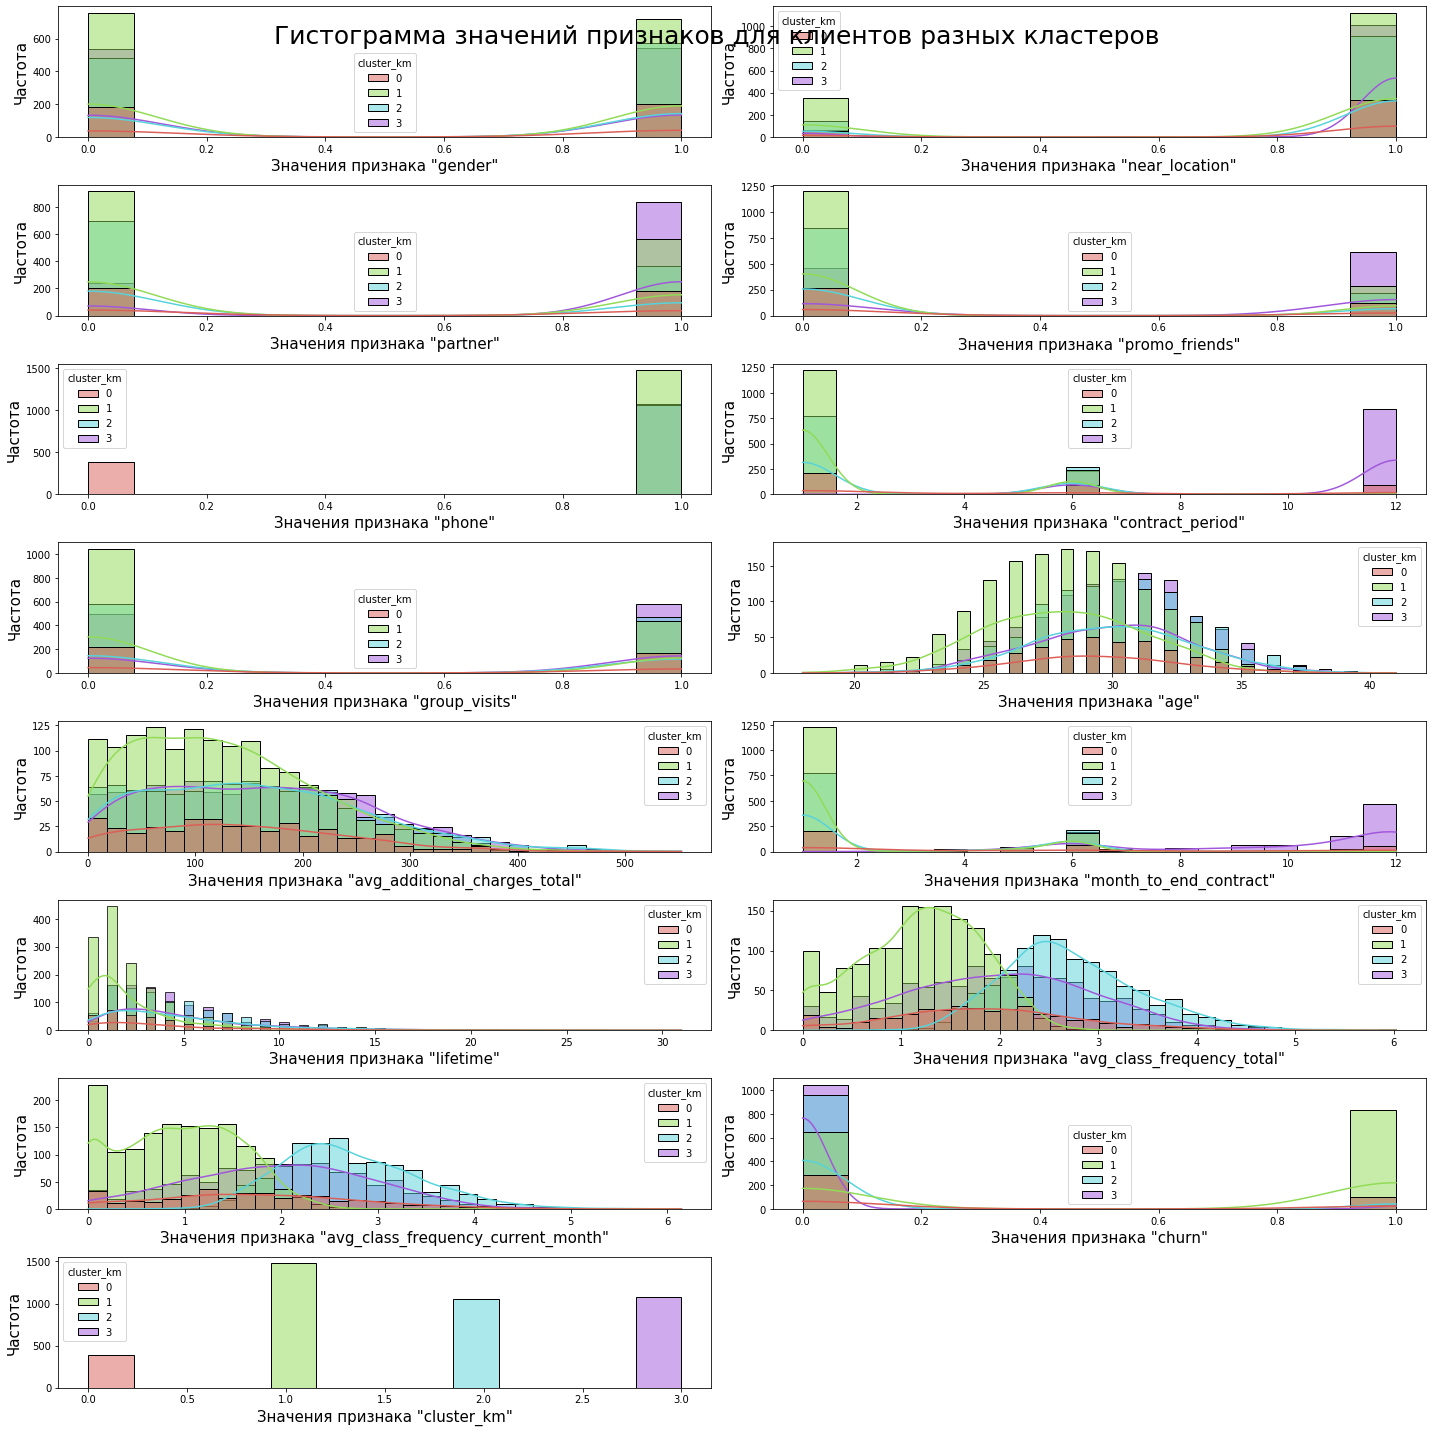

In [30]:
ncols = 2
nrows = int(np.ceil(len(df.columns) / (1.0*ncols)))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
fig.suptitle('Гистограмма значений признаков для клиентов разных кластеров', fontsize=25)
#plot
palette = sns.color_palette("hls",4)
counter = 0
for i in range(nrows):
    for j in range(ncols):
        # Plot when we have data
        ax = axes[i][j]
        
        if counter < len(df.columns):
            ax = sns.histplot(data = df, x = df[df.columns[counter]], kde = True, hue = 'cluster_km', 
                         ax = ax, alpha = 0.5, palette = palette)
            ax.set_xlabel('Значения признака "{}"'.format(df.columns[counter]), fontsize = 15)
            ax.set_ylabel('Частота', fontsize = 15)

        # Remove axis when we no longer have data
        else:
            ax.set_axis_off()

        counter += 1

plt.tight_layout()
plt.show()

Из графиков распределения выделяется наиболее успешный кластер 3 по значениям признаков promo_friends, contact_period, group_visits, churn, month_to_end_contract и partner. Кластер 2 также имеет положительный прогноз по оттоку, то есть клиенты данного кластера не склонны к уходу. По сравнению с кластером 3, в котором значение оттока наименьшее, кластер 2 имеет в целом большую частоту посещаемости, чем выделяется на уровне всех остальных кластеров. 

Похожую тенденцию для противоположных значений можно наблюдать для кластера 1, предварительно охарактеризованных как склонных к оттоку. Например, графики распределения частот посещаемости, lifetime, дополнительных расходов и периода контракта (к настоящему времени и в целом) имеют одностороннее скопление значений кластера 1. 

Распределение значений признаков кластера 0 в целом не выделяется на фоне других, за исключением признака phone, то есть клиеенты данного кластера отличаются от других отсутствием телефона в датабазе. 

Если смотреть на общее количество клиентов разных кластеров, можно отметить, что больше всего клиентов, к сожалению принадлежат к кластеру 1. Меньше всего клиентов имеет кластер 0, отличающийся от других отсутствием телефона.

Посмотрим на общее количество клиентов в кластерах:

In [31]:
df_clusters = df.groupby('cluster_km').agg('count')['age'].reset_index()
df_clusters.rename(columns = {'age':'total_clients'}, inplace = True)
df_clusters

,cluster_km,total_clients
0,0,386
1,1,1479
2,2,1057
3,3,1078


In [32]:
#percent
df_clusters['percent_of_total'] = df_clusters['total_clients']/(df_clusters['total_clients'].sum())*100
df_clusters

,cluster_km,total_clients,percent_of_total
0,0,386,9.650
1,1,1479,36.975
2,2,1057,26.425
3,3,1078,26.950


In [33]:
print('Кластеры 0, 2 и 3 в сумме:')
print('{:.2f}'.format(df_clusters.query('cluster_km == 0 or cluster_km == 2 or cluster_km == 3')['percent_of_total'].sum()), '%')
print('Кластер 1:')
print('{:.2f}'.format(df_clusters.query('cluster_km == 1')['percent_of_total'].sum()), '%')

Кластеры 0, 2 и 3 в сумме:
63.02 %
Кластер 1:
36.98 %


Таким образом, количество клиентов не склонных к уходу больше тех, кто склонен к уходу и составляет 63.02%. 

Посчитаем долю оттока для каждого кластера:

In [34]:
churn_rate = df.query('churn == 1').groupby('cluster_km')['churn'].count().reset_index()
churn_rate

,cluster_km,churn
0,0,103
1,1,828
2,2,98
3,3,32


In [35]:
churn_rate.rename(columns = {'churn':'churn_1'}, inplace = True)
#merge with df_clusters:
df_clusters = df_clusters.merge(churn_rate, on = 'cluster_km')
df_clusters

,cluster_km,total_clients,percent_of_total,churn_1
0,0,386,9.650,103
1,1,1479,36.975,828
2,2,1057,26.425,98
3,3,1078,26.950,32


,cluster_km,total_clients,percent_of_total,churn_1,churn_percent
0,0,386,9.650,103,26.683938
1,1,1479,36.975,828,55.983773
2,2,1057,26.425,98,9.271523
3,3,1078,26.950,32,2.968460


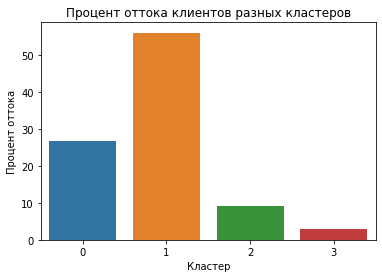

In [36]:
#add new column containing the part of churn == 1:
df_clusters['churn_percent'] = df_clusters['churn_1']/df_clusters['total_clients']*100
display(df_clusters)
#plot
plt.figure()
ax = sns.barplot(x = df_clusters['cluster_km'], y = df_clusters['churn_percent'])
ax.set_xlabel('Кластер')
ax.set_ylabel('Процент оттока')
plt.title('Процент оттока клиентов разных кластеров')
plt.show()

Таким образом, наблюдения и выводы выше о потенциальной успешности кластеров по оттоку подтвердились. Наиболее перспективные клиенты принадлежат к кластерам 2 и 3, кластер 0 занимает среднее значение, а кластер 1 не является перспективным: клиенты принадлежащие к данному кластеру склонны к уходу. 

Распределение значений призака возраст:

In [37]:
df.query('churn == 1')['age'].describe()

count    1061.000000
mean       26.989632
std         2.895163
min        18.000000
25%        25.000000
50%        27.000000
75%        29.000000
max        38.000000
Name: age, dtype: float64

In [38]:
df.query('churn == 0')['age'].describe()

count    2939.000000
mean       29.976523
std         3.009933
min        19.000000
25%        28.000000
50%        30.000000
75%        32.000000
max        41.000000
Name: age, dtype: float64

## Выводы и рекомендации<a id = 'conclusions'><a/>

### Выводы

1. Наиболее перспективные и надежные клиенты относятся к кластерам 3 (2.96% оттока) и 2 (9.27% оттока). 
2. Клиенты принадлежащие к кластеру 1 (55.98% оттока) ненадежны и склонны к уходу. 
3. Признаки свойственные надежным клиентам/факторы способствующие удержанию: 
    - посещение групповых занятий;
    - среднее число посещений в неделю ~2;
    - абонемент более чем на 6 месяцев;
    - работа клиента в компании-партнёре клуба;
    - факт первоначальной записи в рамках акции «приведи друга».
    
4. Надежные клиенты в среднем старше клиентов, склонных к уходу. Средний возраст клинтов в надежных кластерах - 29-30 лет, 25й перцентиль - 28 лет. 
5. Надежные клиенты тратят в среднем больше денег на дополнительные услуги. 
6. Клиенты, тратящие на дополнительные услуги более 200 руб/мес скорее всего не уйдут. 
7. Признаки возможного ухода:
    - менее 1.5 посещений в неделю.
    - абонемент менее чем на 6 месяцев.
    
8. Клиенты компаний-партнеров чаще приходят по приглашению друга. 

### Рекомендации по работе с клиентами

Для удержания клиентов рекомендуем следовать следующим принципам:
1. Распространение рекламы в компаниях партнерах. Проведение специальных акций для сотрудников таких компаний в рамках "Приведи друга". Например, скидки на дополнительные услуги или бесплатный месяц абонемента за трех приглашенных друзей и т.д. 
2. Трекинг среднего количества посещений в неделю. При среднем посещении менее 1.5 раз в неделю - рассылка интересных статей о пользе фитнеса и другие кампании по стимуляции интереса и мотивации к тренировкам.
3. Скидки для постоянных клиентов (более 6 месяцев) для их удержания. 
4. Анализ периода наибольшего оттока клиентов ненадежных групп и на основе полученных данных определение месяца проведения сезона горячих предложений на полугодовой абонемент, так чтобы уменьшить отток клиентов в период наибольшего оттока. 